<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W3D5_initial_commit/tutorials/W3D5_DeepLearning2/W3D5_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day 5, Tutorial 2
# Deep Learning 2: Autoencoder extensions

---
#Tutorial Objectives

The autoencoder with two units in the bottleneck layer (2D) can have better latent space representation with a few changes in the architecture.

In this tutorial, we add capacity by introducing additional hidden layers, introduce a constraint on the geometry of latent space.

![Deep ANN autoencoder](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/ae-ann-3h.png)

In this tutorial, we will
- Improve the representation capacity by introducing additional hidden layers
- Understand the effect of constraints in the geometry of the latent **space**

Video available at https://youtube.com/watch?v=Ai5idexfZbM


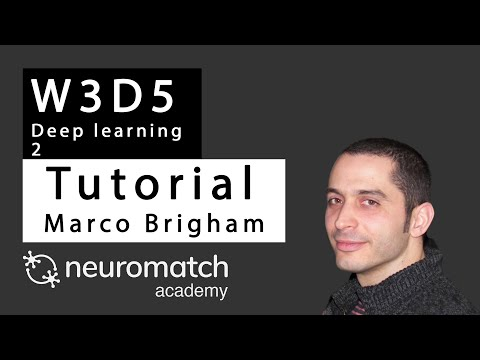

In [1]:
#@title Video: Intro

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Ai5idexfZbM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Setup


Please execute the cell(s) below to initialize the notebook environment.

In [2]:
import numpy as np                 # import numpy
import matplotlib.pyplot as plt    # import matplotlib
from IPython import display        
from IPython.display import YouTubeVideo

import torch
from torch import nn, optim
import torchvision

import sklearn as sk
from sklearn import manifold, decomposition

import plotly.graph_objects as go
from plotly.colors import qualitative

In [3]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

fig_w, fig_h = (8, 6)
plt.rcParams['figure.figsize'] = (fig_w, fig_h)
plt.rcParams['font.size'] = 14

In [4]:
# @title Helper functions

def eval_mse(y_pred, y_true):
    """
    Evaluates mean square error (MSE) between y_pred and y_true
    
    Args:
      y_pred (torch.Tensor)
          prediction samples

      v (numpy array of floats)
          ground truth samples
              
    Returns:
      MSE(y_pred, y_true)
    """

    with torch.no_grad():
        criterion = nn.MSELoss()
        loss = criterion(y_pred, y_true)

    return float(loss)


def eval_bce(y_pred, y_true):
    """
    Evaluates binary cross-entropy (BCE) between y_pred and y_true
    
    Args:
      y_pred (torch.Tensor)
          prediction samples

      v (numpy array of floats)
          ground truth samples
              
    Returns:
      BCE(y_pred, y_true)
    """
    
    with torch.no_grad():
        criterion = nn.BCELoss()
        loss = criterion(y_pred, y_true)

    return float(loss)


def plot_row(images, show_n=10, image_shape=None):
    """
    Plots rows of images from list of iterables (iterables: list, numpy array 
    or torch.Tensor). Also accepts single iterable.
    Randomly selects images in each list element if item count > show_n.
    
    
    Args:
      images (iterable or list of iterables)
          single iterable with images, or list of iterables

      show_n (integer)
          maximum number of images per row

      image_shape (tuple or list)
          original shape of image if vectorized form
             
    Returns:
      Nothing.
    """

    if not isinstance(images, (list, tuple)):
        images = [images]

    for items_idx, items in enumerate(images):

        items = np.array(items)
        if items.ndim==1:
            items = np.expand_dims(items, axis=0)

        if len(items)>show_n:
            selected = np.random.choice(len(items), show_n, replace=False)
            items = items[selected]

        if image_shape is not None:
            items = items.reshape([-1]+list(image_shape))

        fig = plt.figure(figsize=(len(items)*1.5, 2))
        for image_idx, image in enumerate(items):

            plt.subplot(1, len(items), image_idx + 1)
            plt.imshow(image, cmap='gray', vmin=image.min(), vmax=image.max())
            plt.axis('off')

        plt.tight_layout()


def to_s2(u):
    """
    Projects 3D coordinates to spherical coordinates (theta, phi) surface of 
    unit sphere S2.
    theta: [0, pi]
    phi: [-pi, pi]   

    Args:
      u (list, numpy array or torch.Tensor of floats)
          3D coordinates
             
    Returns:
      Sperical coordinates (theta, phi) on surface of unit sphere S2.
    """

    x, y, z = (u[:,0], u[:,1], u[:,2])
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.arctan2(x, y)

    return np.array([theta, phi]).T


def to_u3(s):
    """
    Converts from 2D coordinates on surface of unit sphere S2 to 3D coordinates 
    (on surface of S2), i.e. (theta, phi) ---> (1, theta, phi).
    
    Args:
      s (list, numpy array or torch.Tensor of floats)
          2D coordinates on unit sphere S_2
             
    Returns:
      3D coordinates on surface of unit sphere S_2
    """

    theta, phi = (s[:,0], s[:,1])
    x = np.sin(theta) * np.sin(phi)
    y = np.sin(theta) * np.cos(phi)
    z = np.cos(theta)

    return np.array([x, y, z]).T


def xy_lim(x):
    """
    Return arguments for plt.xlim and plt.ylim calculated from minimum 
    and maximum of x.
    
    
    Args:
      x (list, numpy array or torch.Tensor of floats)
          data to be plotted
             
    Returns:
      Nothing.
    """
    
    x_min = np.min(x, axis=0)
    x_max = np.max(x, axis=0)

    return [x_min[0], x_max[0]], [x_min[1], x_max[1]]
    

def plot_generative(x, decoder_fn, image_shape, n_row=16, s2=False):
    """
    Plots images reconstructed by decoder_fn from a 2D grid in 
    latent space that is determined by minimum and maximum values in x.    
    
    Args:
      x (list, numpy array or torch.Tensor of floats)
          2D or 3D coordinates in latent space 

      decoder_fn (integer)
          function returning vectorized images from 2D latent space coordinates

      image_shape (tuple or list)
          original shape of image

      n_row (integer)
          number of rows in grid

      s2 (boolean)
          convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

    Returns:
      Nothing.
    """

    if s2:
        x = to_s2(np.array(x))

    xlim, ylim = xy_lim(np.array(x))
    
    dx = (xlim[1]-xlim[0])/n_row
    grid = [np.linspace(ylim[0]+dx/2, ylim[1]-dx/2, n_row),
            np.linspace(xlim[0]+dx/2, xlim[1]-dx/2, n_row)]

    canvas = np.zeros((image_shape[0]*n_row, image_shape[1]*n_row))

    cmap = plt.get_cmap('gray')

    for j, latent_y in enumerate(grid[0][::-1]):
        for i, latent_x in enumerate(grid[1]):

            latent = np.array([latent_x, latent_y], dtype=np.float32)

            if s2:
                latent = to_u3(np.expand_dims(latent, axis=0))

            with torch.no_grad():
                x_decoded = decoder_fn(torch.from_numpy(latent))
            
            x_decoded = x_decoded.reshape(image_shape)

            canvas[j*image_shape[0]: (j+1)*image_shape[0],
                   i*image_shape[1]: (i+1)*image_shape[1]] = x_decoded
    
    plt.imshow(canvas, cmap=cmap, vmin=canvas.min(), vmax=canvas.max())
    plt.axis('off')


def plot_latent(x, y, show_n=500, s2=False, fontdict=None):
    """
    Plots in 2D latent space locations the digit class of each sample.
    
    Args:
      x (list, numpy array or torch.Tensor of floats)
          2D coordinates in latent space 

      y (list, numpy array or torch.Tensor of floats)
          digit class of each sample

      n_row (integer)
          number of samples

      s2 (boolean)
          convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

      fontdict (dictionary)
          style option for plt.text
             
    Returns:
      Nothing.
    """

    if fontdict is None:
        fontdict = {'weight': 'bold', 'size': 10}

    if s2:
        x = to_s2(np.array(x))

    cmap = plt.get_cmap('tab10')

    if len(x)>show_n:
        selected = np.random.choice(len(x), show_n, replace=False)
        x = x[selected]
        y = y[selected]

    for my_x, my_y in zip(x, y):
        plt.text(my_x[0], my_x[1], str(int(my_y)),
                 color=cmap(int(my_y)/10.),
                 fontdict=fontdict,
                 alpha=0.8)
        
    xlim, ylim = xy_lim(np.array(x))
    plt.xlim(xlim)
    plt.ylim(ylim)


def plot_latent_generative(x, y, decoder_fn, image_shape, s2=False, title=None):
    """
    Two horizontal subplots generated with plot_latent and plot_generative. 

    Args:
      x (list, numpy array or torch.Tensor of floats)
          2D coordinates in latent space 

      y (list, numpy array or torch.Tensor of floats)
          digit class of each sample

      decoder_fn (integer)
          function returning vectorized images from 2D latent space coordinates

      image_shape (tuple or list)
          original shape of image

      s2 (boolean)
          convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)
          
      title (string)
          plot title
             
    Returns:
      Nothing.
    """

    fig = plt.figure(figsize=(12,6))

    if title is not None:
        fig.suptitle(title, y=1.05, fontsize=16)

    ax = fig.add_subplot(121)
    ax.set_title('Latent space map')
    plot_latent(x, y, s2=s2)

    ax = fig.add_subplot(122)
    ax.set_title('Reconstruction grid')    
    plot_generative(x, decoder_fn, image_shape, s2=s2)

    plt.tight_layout()
    plt.show()


def plot_latent_3d(my_x, my_y, show_text=True, show_n=500):
    """
    Plot digit class or marker in 3D latent space coordinates. 

    Args:
      my_x (list, numpy array or torch.Tensor of floats)
          2D coordinates in latent space 

      my_y (list, numpy array or torch.Tensor of floats)
          digit class of each sample

      show_text (boolean)
          whether to show text

      image_shape (tuple or list)
          original shape of image

      s2 (boolean)
          convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)
          
      title (string)
          plot title
             
    Returns:
      Nothing.
    """

    layout = {'margin': {'l': 0, 'r': 0, 'b': 0, 't': 0},
              'scene': {'xaxis': {'showspikes': False},
                        'yaxis': {'showspikes': False},
                        'zaxis': {'showspikes': False}}
              }

    selected_idx = np.random.choice(len(my_x), show_n, replace=False)

    colors = [qualitative.T10[idx] for idx in my_y[selected_idx]]

    x = my_x[selected_idx,0] 
    y = my_x[selected_idx,1]
    z = my_x[selected_idx,2]

    text = my_y[selected_idx]

    if show_text:

        trace = go.Scatter3d(x=x, y=y, z=z, text=text,
                             mode='text',
                             textfont={'color': colors,
                                       'size': 12}
                            )
        
        layout['hovermode'] = False

    else:
        
        trace = go.Scatter3d(x=x, y=y, z=z, text=text,
                             hoverinfo='text',
                             mode='markers',
                             marker={'size': 5,
                                     'color': colors,
                                     'opacity': 0.8}
                             )      

    fig = go.Figure(data=trace, layout=layout)

    fig.show()


def runSGD(net, input_train, input_test, criterion='bce', 
                n_epochs=10, batch_size=32, verbose=True):
    """
    Trains autoencoder network with stochastic gradient descent with Adam 
    optimizer and loss criterion. Train samples are shuffled, and loss is 
    displayed at the end of each opoch for both MSE and BCE. Plots training loss 
    at each minibatch (maximum of 500 randomly selected values).

    Args:
      net (torch network)
          ANN network (nn.Module)

      input_train (torch.Tensor)
          vectorized input images from train set

      input_test (torch.Tensor)
          vectorized input images from test set

      criterion (string)
          train loss: 'bce' or 'mse'

      n_epochs (boolean)
          number of full iterations of training data
          
      batch_size (integer)
          number of element in mini-batches

      verbose (boolean)
          whether to print epoch loss and training loss plot
             
    Returns:
      Nothing.
    """

    # Initialize loss function
    if criterion=='mse':
        loss_fn = nn.MSELoss()
    elif criterion=='bce':
        loss_fn = nn.BCELoss()
    else:
        print('Please specify either "mse" or "bce" for loss criterion')

    # Initialize SGD optimizer
    optimizer = optim.Adam(net.parameters())

    # Placeholder for loss
    track_loss = []

    print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
    for i in range(n_epochs):

        shuffle_idx = np.random.permutation(len(input_train))
        batches = torch.split(input_train[shuffle_idx], batch_size)
        
        for batch in batches:

            output_train = model(batch)
            loss = loss_fn(output_train, batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Keep track of loss at each epoch
            track_loss += [float(loss)]
        
        loss_epoch = '{}/{}'.format(i+1, n_epochs)
        with torch.no_grad():
            output_train = model(input_train)
            loss_train = loss_fn(output_train, input_train)
            loss_epoch += '\t {:.4f}'.format(loss_train)

            output_test = model(input_test)
            loss_test = loss_fn(output_test, input_test)
            loss_epoch += '\t\t {:.4f}'.format(loss_test)

        if verbose:
            print(loss_epoch)

    # Print loss
    loss_mse = '\nmse\t {:0.4f}'.format(eval_mse(output_train, input_train))
    loss_mse += '\t\t {:0.4f}'.format(eval_mse(output_test, input_test))
    print(loss_mse)

    loss_bce = 'bce\t {:0.4f}'.format(eval_bce(output_train, input_train))
    loss_bce += '\t\t {:0.4f}'.format(eval_bce(output_test, input_test))
    print(loss_bce)

    # Plot loss
    if verbose:
        step = int(np.ceil(len(track_loss)/500))
        plt.figure()
        plt.plot(track_loss[::step], 'C1')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.xlim([0, None])
        plt.ylim([0, None])
        plt.show()


class NormalizeLayer(nn.Module):
    """
    pyTorch layer (nn.Module) that normalizes activations by their L2 norm.

    Args:
        None.
             
    Returns:
        Object inherited from nn.Module class.
    """

    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return nn.functional.normalize(x, p=2, dim=1)    

## Download  and prepare MNIST dataset
We use the function `torchvision.datasets.MNIST` to download the dataset and assign train and test sets to (`x_train`, `y_train`) and (`x_test`, `y_test`), respectively.

The variable `input_size` stores the size of *vectorized* versions of the images `input_train` and `input_test`, for train and test images, respectively.

**Instructions**
* Please execute the cell below:

In [5]:
dataset_train = torchvision.datasets.MNIST('../data', train=True, download=True)
dataset_test = torchvision.datasets.MNIST('../data', train=False, download=True)

x_train = dataset_train.data
y_train = dataset_train.targets

x_test = dataset_test.data
y_test = dataset_test.targets

x_train = x_train/255.
x_test = x_test/255.

image_shape = x_train.shape[1:]

input_size = np.prod(image_shape)

input_train = x_train.reshape([-1, input_size])
input_test = x_test.reshape([-1, input_size])

test_selected_idx = np.random.choice(len(x_test), 10, replace=False)
train_selected_idx = np.random.choice(len(x_train), 10, replace=False)

print('size input_size', input_size)
print('shape input_train', input_train.shape)
print('shape input_train', input_test.shape)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.



size input_size 784
shape input_train torch.Size([60000, 784])
shape input_train torch.Size([10000, 784])


## Deeper autoencoder (2D)
The performance of the shallow autoencoder with 2D latent space from the previous tutorial was comparable to PCA. This behavior is unsurprising since training the network with linear (identity) activation functions under mse loss is [very similar to performing PCA](https://arxiv.org/abs/1804.10253).

Adding two additional hidden layers increases the representational power of the network.

### Exercise 1: Build deeper autoencoder (2D)

Implement this deeper version of the ANN autoencoder by adding three hidden layers.

**Hints:**
* Add three additional layers and activation functions to the network
* Adjust the definitions of `encoder` and `decoder`

In [6]:
# Exercise 1
encoding_size = 2

model = nn.Sequential(nn.Linear(input_size, int(input_size/2)),
                      nn.PReLU(),
                      nn.Linear(int(input_size/2), encoding_size*32)
#################################################
## TODO for students: add layers to build deeper autoencoder
# --> insert your code here

# <--
#################################################
                      )

encoder = model[:2]
decoder = model[2:]

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

print('Autoencoder', '\n\n', model)
print('Encoder', '\n\n', encoder)
print('Decoder', '\n\n', decoder)

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=64, bias=True)
)
Encoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
)
Decoder 

 Sequential(
  (2): Linear(in_features=392, out_features=64, bias=True)
)


In [7]:
# to_remove solution

encoding_size = 2

model = nn.Sequential(nn.Linear(input_size, int(input_size/2)),
                      nn.PReLU(),
                      nn.Linear(int(input_size/2), encoding_size*32),
                      nn.PReLU(),
                      nn.Linear(encoding_size*32, encoding_size),
                      nn.PReLU(),
                      nn.Linear(encoding_size, encoding_size*32),
                      nn.PReLU(),
                      nn.Linear(encoding_size*32, int(input_size/2)),
                      nn.PReLU(),
                      nn.Linear(int(input_size/2), input_size),
                      nn.Sigmoid())

encoder = model[:6]
decoder = model[6:]

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

print('Autoencoder', '\n\n', model)
print('Encoder', '\n\n', encoder)
print('Decoder', '\n\n', decoder)

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=64, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): PReLU(num_parameters=1)
  (6): Linear(in_features=2, out_features=64, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Linear(in_features=64, out_features=392, bias=True)
  (9): PReLU(num_parameters=1)
  (10): Linear(in_features=392, out_features=784, bias=True)
  (11): Sigmoid()
)
Encoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=64, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): PReLU(num_parameters=1)
)
Decoder 

 Sequential(
  (6): Linear(in_features=2, out_features=64, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Linear(in_features=64, out_featur

### Train the autoencoder

Train the network for `n_epochs=10` epochs with `batch_size=128`.

**Instructions**
* Please execute the cells below:



Epoch 	 Loss train 	 Loss test

1/10	 0.2071		 0.2075
2/10	 0.1970		 0.1977
3/10	 0.1900		 0.1907
4/10	 0.1861		 0.1871
5/10	 0.1830		 0.1844
6/10	 0.1805		 0.1821
7/10	 0.1786		 0.1800
8/10	 0.1773		 0.1790
9/10	 0.1756		 0.1776
10/10	 0.1744		 0.1767

mse	 0.0379		 0.0387
bce	 0.1744		 0.1767


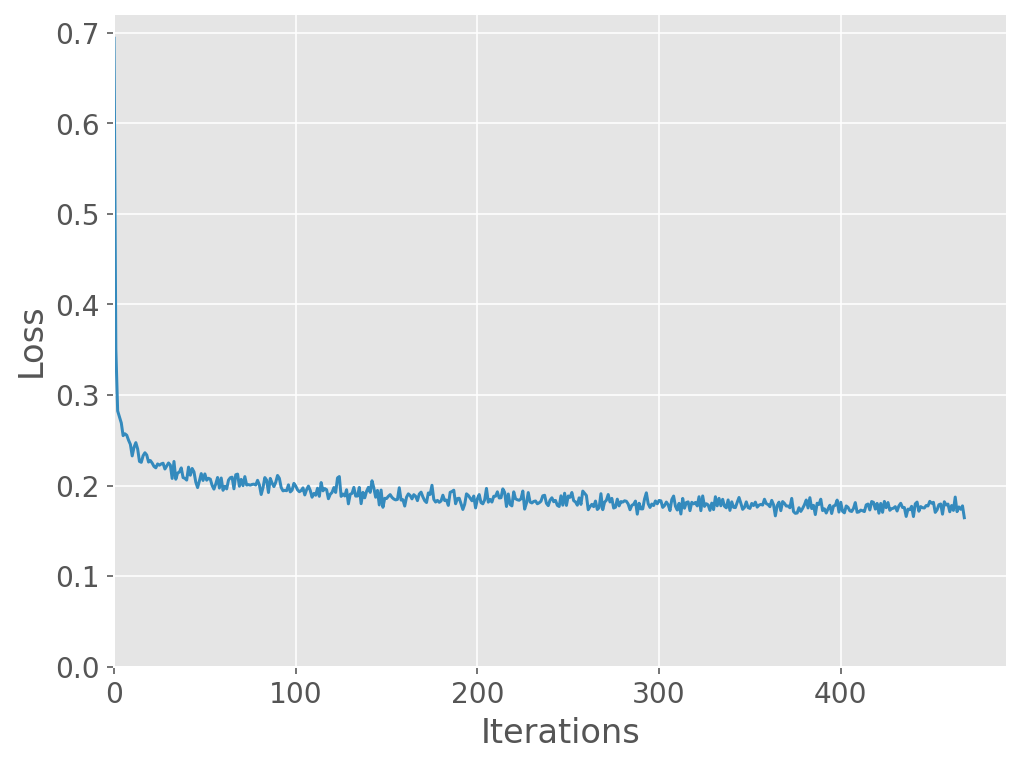

In [8]:
n_epochs = 10
batch_size = 128

runSGD(model, input_train, input_test, n_epochs=n_epochs, batch_size=batch_size)

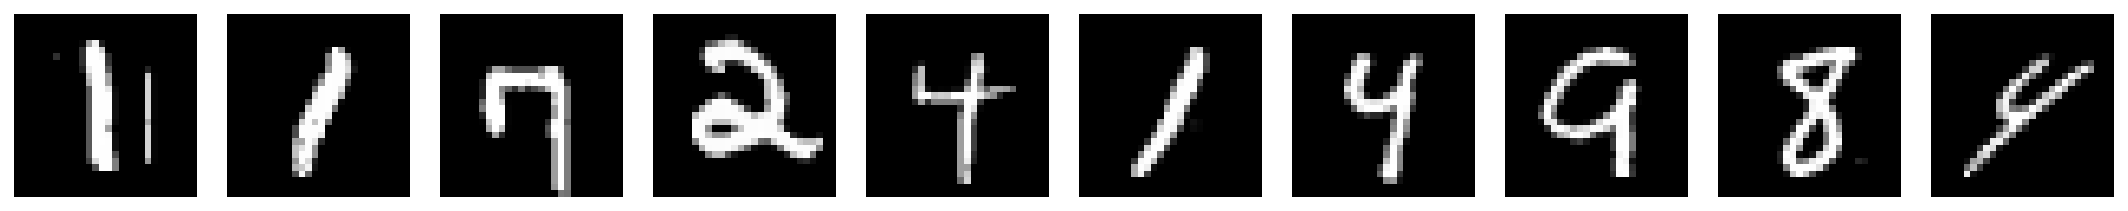

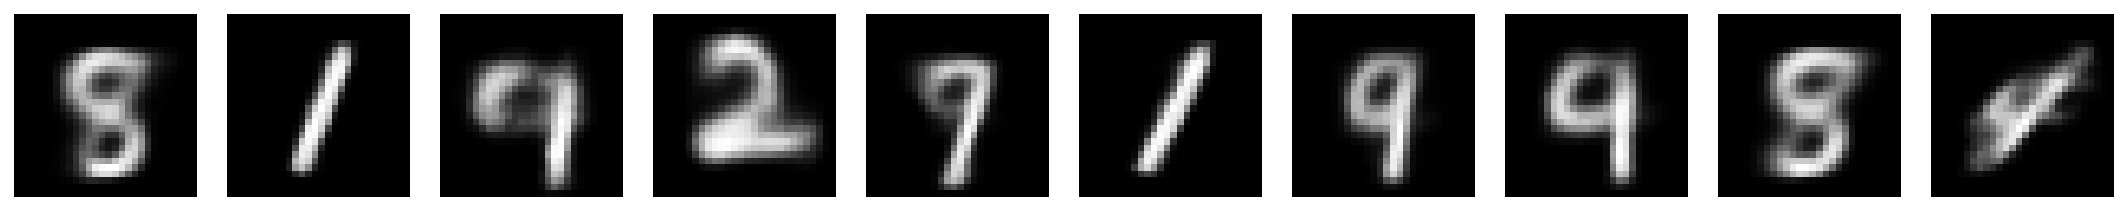

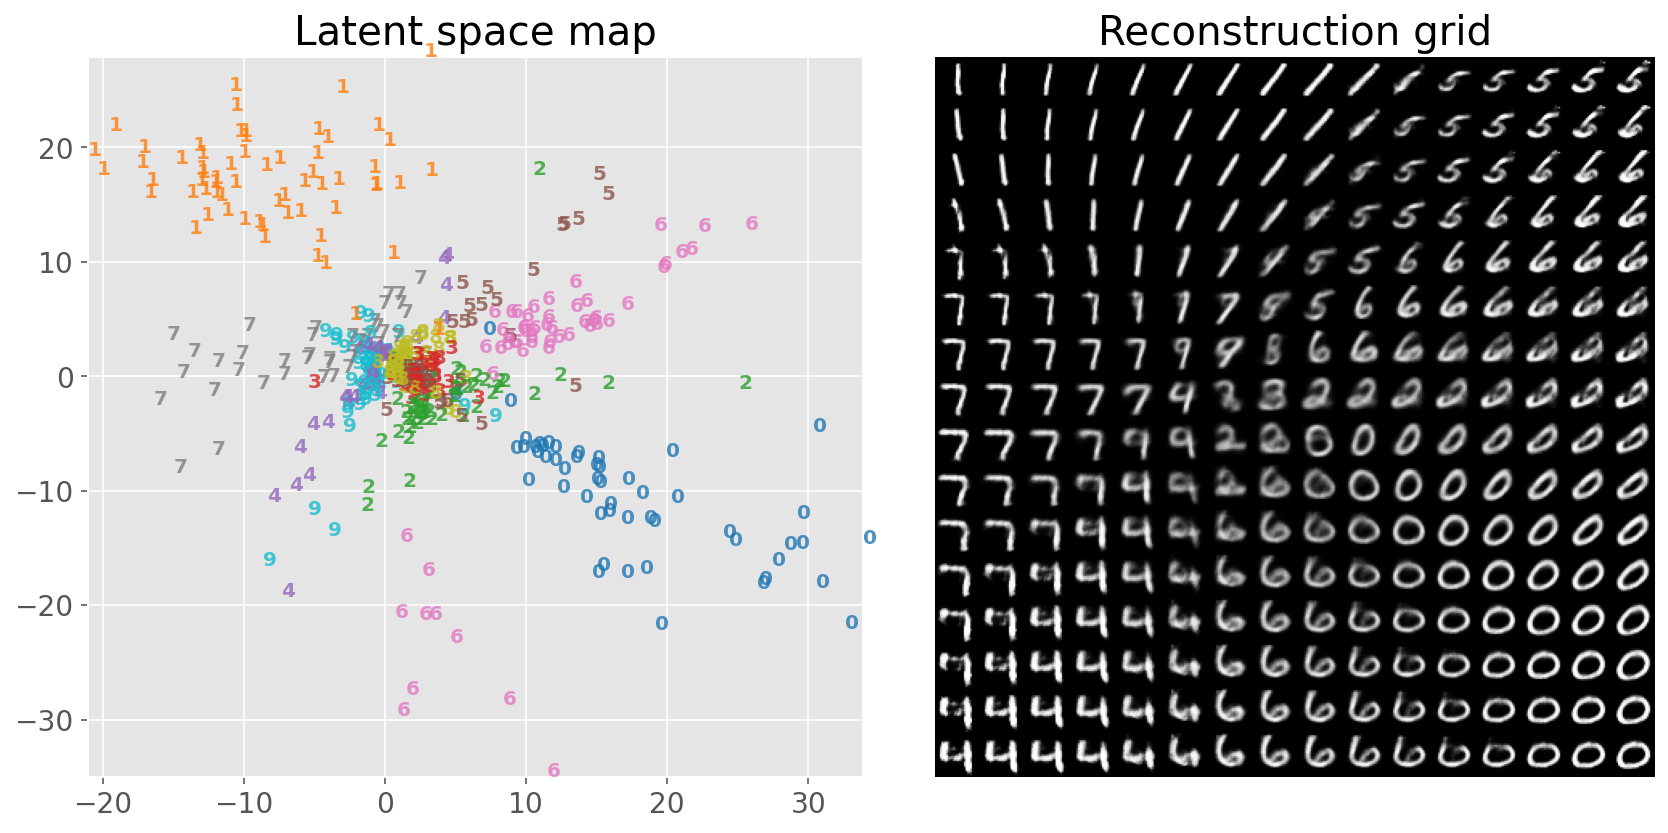

In [9]:
with torch.no_grad():
  output_test = model(input_test)
  latent_test = encoder(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]], 
         image_shape=image_shape)

plot_latent_generative(latent_test, y_test, decoder, 
                       image_shape=image_shape)

## Spherical latent space

The previous networks generate representations that typically spread from coordinate `(0, 0)` in different directions. This effect is due to the initialization of weights that are distributed randomly around `0`, and in particular, also in the bottleneck layer.

Adding a third unit to the bottleneck layer defines a coordinate $(x, y, z)$ in 3D space. The latent space from such a network will still spread out from `(0, 0, 0)`.

Collapsing the latent space on the surface of a sphere removes the possibility of spreading far in any direction. This constraint generates representation that fills the surface of the sphere.

![Unit sphere S2](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/unit_sphere.png)

Projecting to the surface of the sphere is implemented by dividing the coordinates $(x, y, z)$ by their $L_2$ norm.

$(x, y, z)\longmapsto (s_x, s_y, s_z)=(x, y, z)/\|(x, y, z)\|_2=(x, y, z)/ \sqrt{x^2+y^2+z^2}$

This mapping projects to the surface of the [$S_2$ sphere](https://en.wikipedia.org/wiki/N-sphere) with unit radius. (Why?)

### Build and train autoencoder (3D)

We start by adding an additional unit to the bottleneck layer and visualize the latent space in 3D.

Train the network for `n_epochs=5` epochs with `batch_size=128`.

**Hint:**
* Please execute the cell(s) below

In [10]:
encoding_size = 3

model = nn.Sequential(nn.Linear(input_size, int(input_size/2)),
                      nn.PReLU(),
                      nn.Linear(int(input_size/2), encoding_size*32),
                      nn.PReLU(),
                      nn.Linear(encoding_size*32, encoding_size),
                      nn.PReLU(),
                      nn.Linear(encoding_size, encoding_size*32),
                      nn.PReLU(),
                      nn.Linear(encoding_size*32, int(input_size/2)),
                      nn.PReLU(),
                      nn.Linear(int(input_size/2), input_size),
                      nn.Sigmoid())

encoder = model[:6]
decoder = model[6:]


print('Autoencoder', '\n\n', model)
# print('Encoder', '\n\n', encoder)
# print('Decoder', '\n\n', decoder)

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=96, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=96, out_features=3, bias=True)
  (5): PReLU(num_parameters=1)
  (6): Linear(in_features=3, out_features=96, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Linear(in_features=96, out_features=392, bias=True)
  (9): PReLU(num_parameters=1)
  (10): Linear(in_features=392, out_features=784, bias=True)
  (11): Sigmoid()
)


Epoch 	 Loss train 	 Loss test
1/10	 0.1926		 0.1928
2/10	 0.1779		 0.1778
3/10	 0.1706		 0.1709
4/10	 0.1660		 0.1668
5/10	 0.1628		 0.1640
6/10	 0.1600		 0.1614
7/10	 0.1584		 0.1603
8/10	 0.1566		 0.1584
9/10	 0.1550		 0.1576
10/10	 0.1540		 0.1566

mse	 0.0307		 0.0315
bce	 0.1540		 0.1566


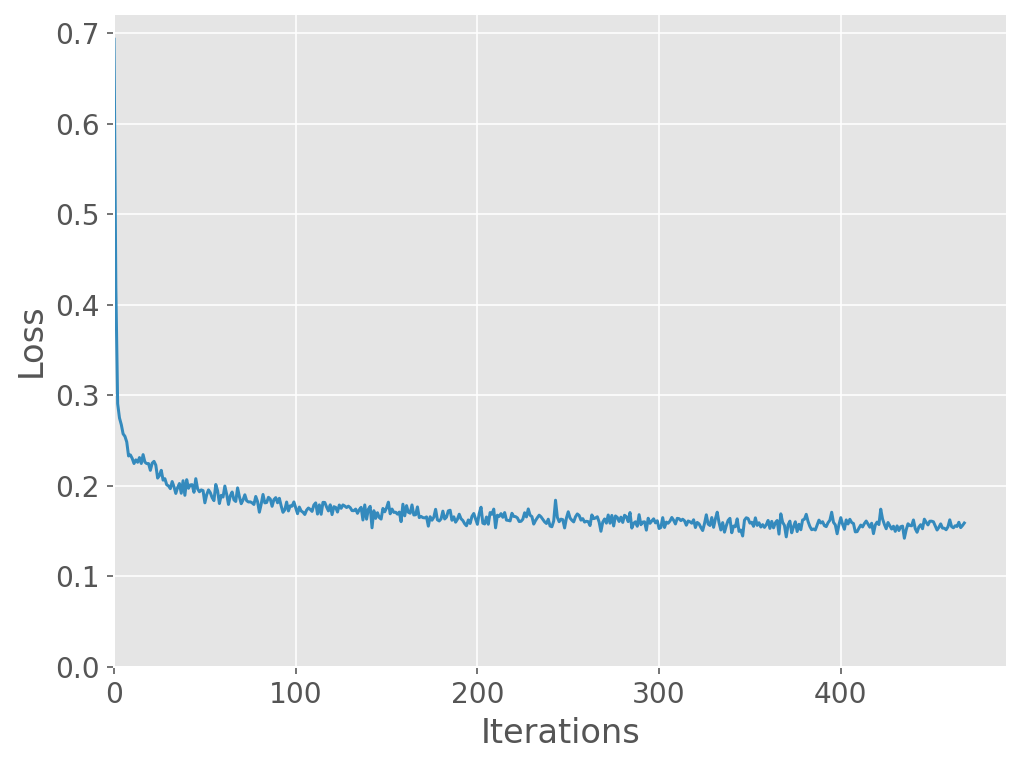

In [11]:
n_epochs = 10
batch_size = 128

runSGD(model, input_train, input_test, n_epochs=n_epochs, batch_size=batch_size)

### Build and train autoencoder (3D)

We start by adding one unit to the bottleneck layer and visualize the latent space in 3D.

Train the network for `n_epochs=5` epochs with `batch_size=128`.

**Instructions**
* Please execute the cell(s) below:

**Helper function**: `plot_latent_3d`

In [12]:
help(plot_latent_3d)

Help on function plot_latent_3d in module __main__:

plot_latent_3d(my_x, my_y, show_text=True, show_n=500)
    Plot digit class or marker in 3D latent space coordinates. 
    
    Args:
      my_x (list, numpy array or torch.Tensor of floats)
          2D coordinates in latent space 
    
      my_y (list, numpy array or torch.Tensor of floats)
          digit class of each sample
    
      show_text (boolean)
          whether to show text
    
      image_shape (tuple or list)
          original shape of image
    
      s2 (boolean)
          convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)
          
      title (string)
          plot title
             
    Returns:
      Nothing.



In [13]:
with torch.no_grad():
  latent_test = encoder(input_test)
    
plot_latent_3d(latent_test, y_test)

#### Exercise 2: Build deep autoencoder (2D) with latent spherical space
We now constrain the latent space to the surface of a sphere $S_2$.


**Instructions**
* Add the custom layer `NormalizeLayer` after the bottleneck layer
* Adjust the definitions of `encoder` and `decoder`
* Experiment with keyword `show_text=False` for `plot_latent_3d`

**Helper function**: `NormalizeLayer`

If you want to inspect what this function does, uncomment the line below.

In [14]:
#help(NormalizeLayer)

In [15]:
# Exercise 2
encoding_size = 3

model = nn.Sequential(nn.Linear(input_size, int(input_size/2)),
                      nn.PReLU(),
                      nn.Linear(int(input_size/2), encoding_size*32),
                      nn.PReLU(),
                      nn.Linear(encoding_size*32, encoding_size),
                      nn.PReLU(),
                      #################################################
                      ## TODO for students: add custom normalize layer
                      # --> insert your code here

                      # <--
                      #################################################                      
                      nn.Linear(encoding_size, encoding_size*32),
                      nn.PReLU(),
                      nn.Linear(encoding_size*32, int(input_size/2)),
                      nn.PReLU(),
                      nn.Linear(int(input_size/2), input_size),
                      nn.Sigmoid())
# Adjust the values to separate correctly your model
encoder = model[:6]
decoder = model[6:]

print('Autoencoder', '\n\n', model)
print('Encoder', '\n\n', encoder)
print('Decoder', '\n\n', decoder)

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=96, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=96, out_features=3, bias=True)
  (5): PReLU(num_parameters=1)
  (6): Linear(in_features=3, out_features=96, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Linear(in_features=96, out_features=392, bias=True)
  (9): PReLU(num_parameters=1)
  (10): Linear(in_features=392, out_features=784, bias=True)
  (11): Sigmoid()
)
Encoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=96, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=96, out_features=3, bias=True)
  (5): PReLU(num_parameters=1)
)
Decoder 

 Sequential(
  (6): Linear(in_features=3, out_features=96, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Linear(in_features=96, out_featur

In [16]:
# to_remove solution
encoding_size = 3

model = nn.Sequential(nn.Linear(input_size, int(input_size/2)),
                      nn.PReLU(),
                      nn.Linear(int(input_size/2), encoding_size*32),
                      nn.PReLU(),
                      nn.Linear(encoding_size*32, encoding_size),
                      nn.PReLU(),
                      NormalizeLayer(),
                      nn.Linear(encoding_size, encoding_size*32),
                      nn.PReLU(),
                      nn.Linear(encoding_size*32, int(input_size/2)),
                      nn.PReLU(),
                      nn.Linear(int(input_size/2), input_size),
                      nn.Sigmoid())

# Adjust the values to separate correctly your model
encoder = model[:7]
decoder = model[7:]

print('Autoencoder', '\n\n', model)
print('Encoder', '\n\n', encoder)
print('Decoder', '\n\n', decoder)

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=96, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=96, out_features=3, bias=True)
  (5): PReLU(num_parameters=1)
  (6): NormalizeLayer()
  (7): Linear(in_features=3, out_features=96, bias=True)
  (8): PReLU(num_parameters=1)
  (9): Linear(in_features=96, out_features=392, bias=True)
  (10): PReLU(num_parameters=1)
  (11): Linear(in_features=392, out_features=784, bias=True)
  (12): Sigmoid()
)
Encoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=96, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=96, out_features=3, bias=True)
  (5): PReLU(num_parameters=1)
  (6): NormalizeLayer()
)
Decoder 

 Sequential(
  (7): Linear(in_features=3, out_features=96, bias=True)
  (8): PReLU(num_param

Epoch 	 Loss train 	 Loss test
1/10	 0.2072		 0.2069
2/10	 0.1930		 0.1936
3/10	 0.1880		 0.1884
4/10	 0.1842		 0.1850
5/10	 0.1814		 0.1823
6/10	 0.1800		 0.1811
7/10	 0.1786		 0.1796
8/10	 0.1765		 0.1772
9/10	 0.1771		 0.1782
10/10	 0.1750		 0.1761

mse	 0.0380		 0.0384
bce	 0.1750		 0.1761


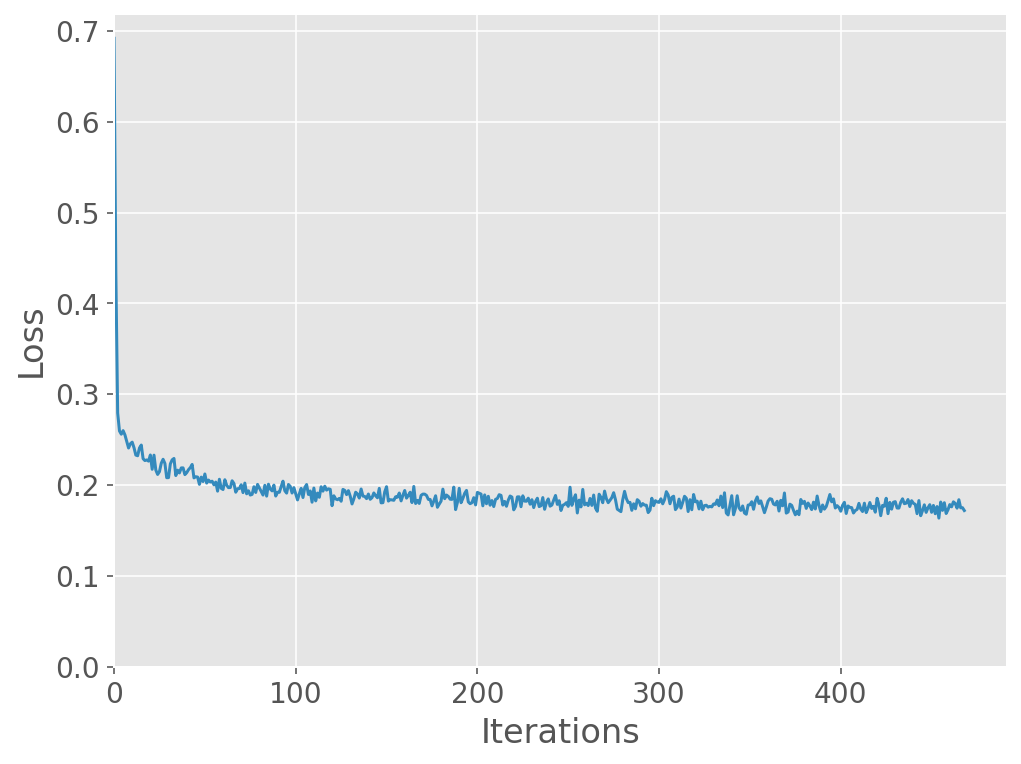

In [17]:
n_epochs = 10
batch_size = 128

runSGD(model, input_train, input_test, n_epochs=n_epochs, batch_size=batch_size)

In [18]:
with torch.no_grad():
  latent_test = encoder(input_test)
    
plot_latent_3d(latent_test, y_test)

### Visualize latent space on surface of $S_2$
The 3D coordinates $(s_x, s_y, s_z)$ on the surface of the unit sphere $S_2$  can be mapped to [spherical coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system) $(r, \theta, \phi)$, as follows:

$$
\begin{aligned}
r &= \sqrt{s_x^2 + s_y^2 + s_z^2} \\
\phi &= \arctan \frac{s_y}{s_x} \\
\theta &= \arccos\frac{s_z}{r}
\end{aligned}
$$

![Spherical coordinates](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/spherical_coords.png)

What is the domain (numerical range) spanned by  ($\theta, \phi)$?

The only degrees of freedom on the surface of the sphere $S_2$  are $(\theta, \phi)$, which is again a 2D representation. Adding the keyword `s2=True` to `plot_latent_generative` makes the necessary adjustment.

Task: Check the numerical range of the plot axis to help identify $\theta$ and $\phi$, and visualize the unfolding of the 3D plot from the previous exercise.

**Instructions:**
* Please execute the cells below

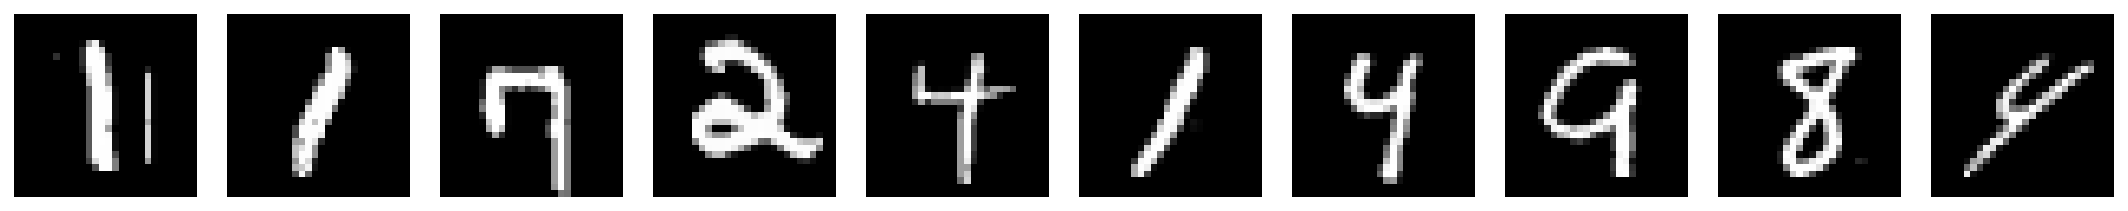

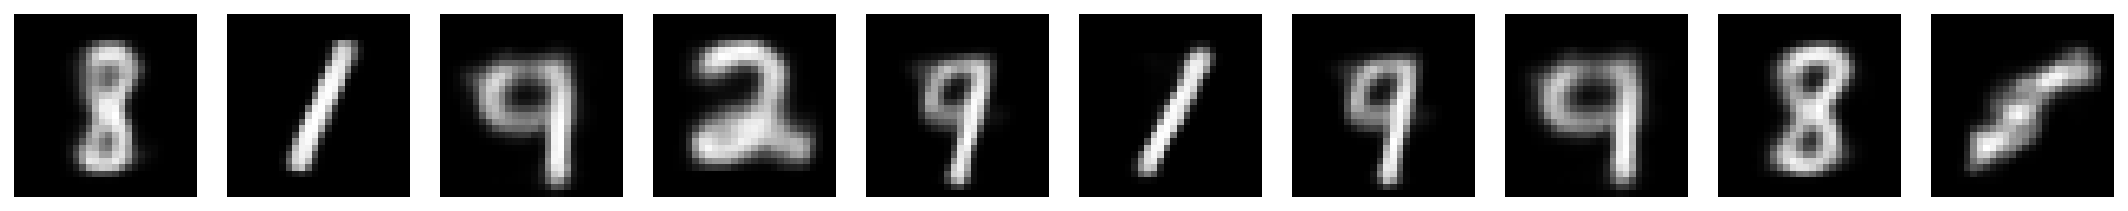

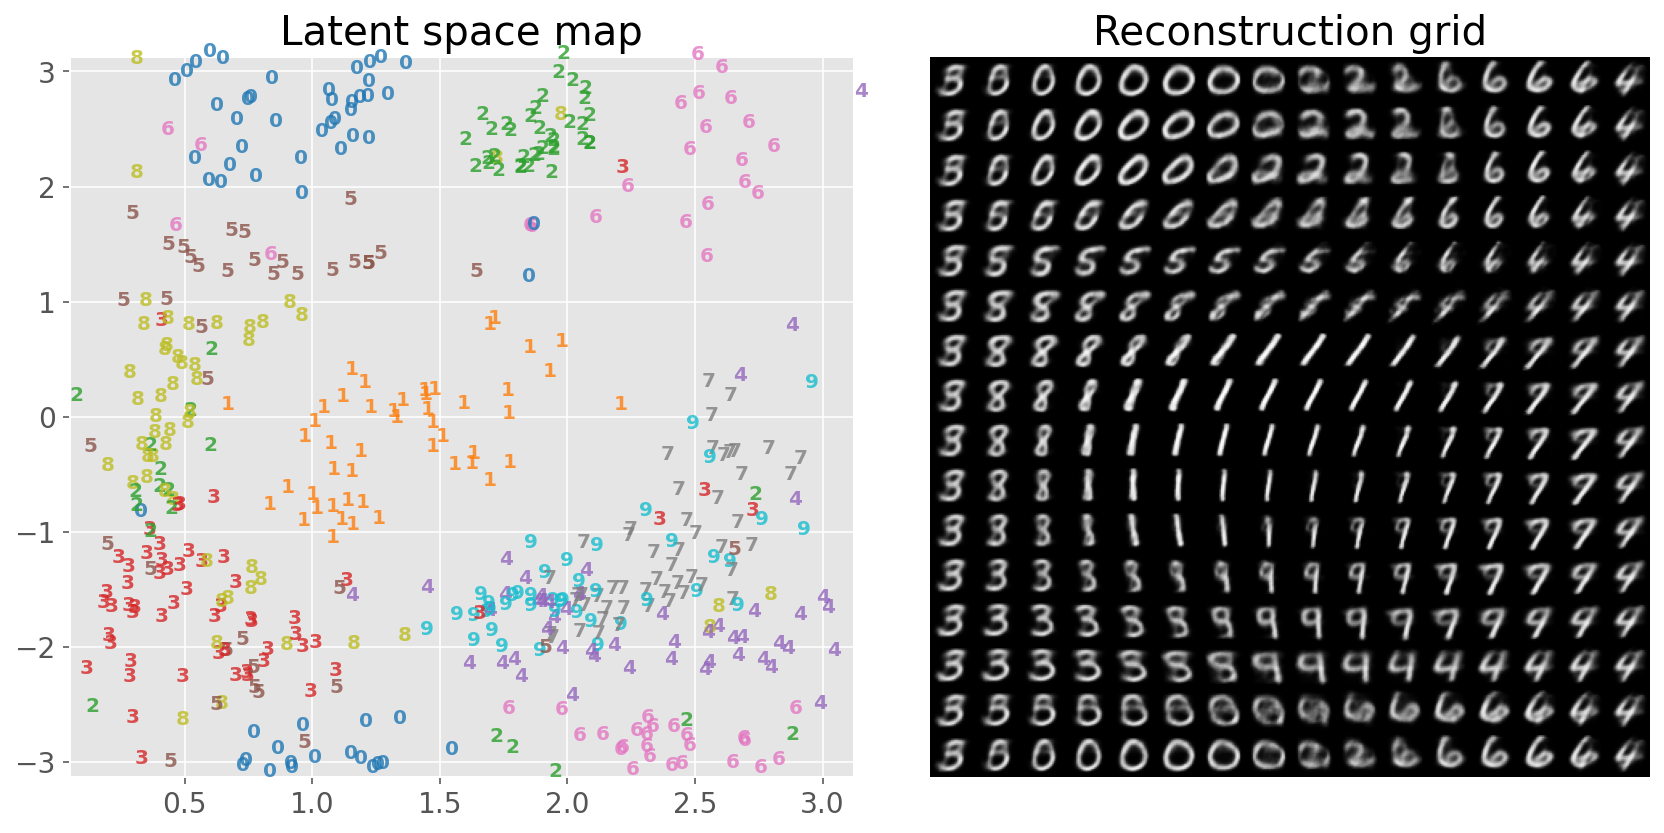

In [19]:
with torch.no_grad():
  output_test = model(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]], image_shape=image_shape)

plot_latent_generative(latent_test, y_test, decoder, 
                       image_shape=image_shape, s2=True)

## Summary
In this notebook, we learned two techniques to improve representation capacity: adding a few hidden layers and projecting latent space to the surface of the sphere $S_2$.

**The expressive power of autoencoder improves by adding a few hidden layers. Projecting latent space on the surface of the sphere may not always produce lower loss but often is more visually pleasing.**

In the next notebook, we use these autoencoder architectures in several toy applications to understand the way autoencoders
build internal representations of the world.